In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dataset_path = '/content/drive/My Drive/EuroSAT_RGB/train'
test_dataset_path = '/content/drive/My Drive/EuroSAT_RGB/test'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class DinoV2Model(nn.Module):
    def __init__(self, num_classes=4):
        super(DinoV2Model, self).__init__()
        self.model = AutoModel.from_pretrained("facebook/dinov2-base-imagenet1k-1-layer")
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.model(x).last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(outputs)
        return logits

# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DinoV2Model(num_classes=4)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/58.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/353M [00:00<?, ?B/s]

DinoV2Model(
  (model): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )

Epoch 1/10: 100%|██████████| 25/25 [05:14<00:00, 12.59s/it]


Epoch 1, Train Loss: 1.5876, Train Accuracy: 44.38%


Epoch 2/10: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Epoch 2, Train Loss: 0.7736, Train Accuracy: 59.62%


Epoch 3/10: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Epoch 3, Train Loss: 0.5678, Train Accuracy: 73.38%


Epoch 4/10: 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


Epoch 4, Train Loss: 0.4305, Train Accuracy: 82.12%


Epoch 5/10: 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


Epoch 5, Train Loss: 0.3852, Train Accuracy: 84.38%


Epoch 6/10: 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Epoch 6, Train Loss: 0.3821, Train Accuracy: 85.12%


Epoch 7/10: 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


Epoch 7, Train Loss: 0.2756, Train Accuracy: 89.62%


Epoch 8/10: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Epoch 8, Train Loss: 0.2037, Train Accuracy: 91.88%


Epoch 9/10: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Epoch 9, Train Loss: 0.2257, Train Accuracy: 92.38%


Epoch 10/10: 100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


Epoch 10, Train Loss: 0.1925, Train Accuracy: 93.25%


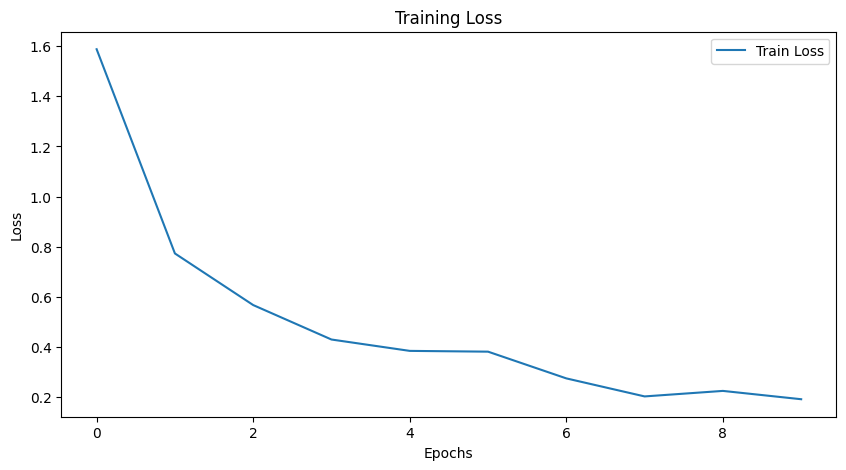

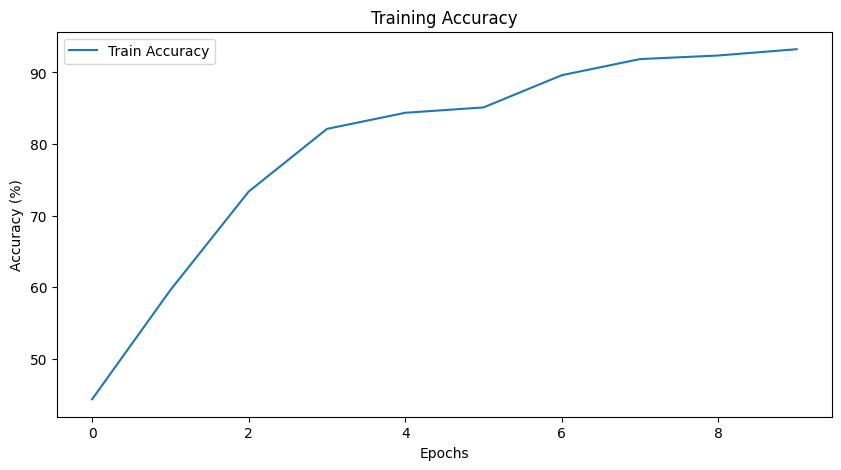

In [5]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss_history = []
train_acc_history = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training step
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Testing: 100%|██████████| 5/5 [01:21<00:00, 16.27s/it]


Test Accuracy: 90.71%


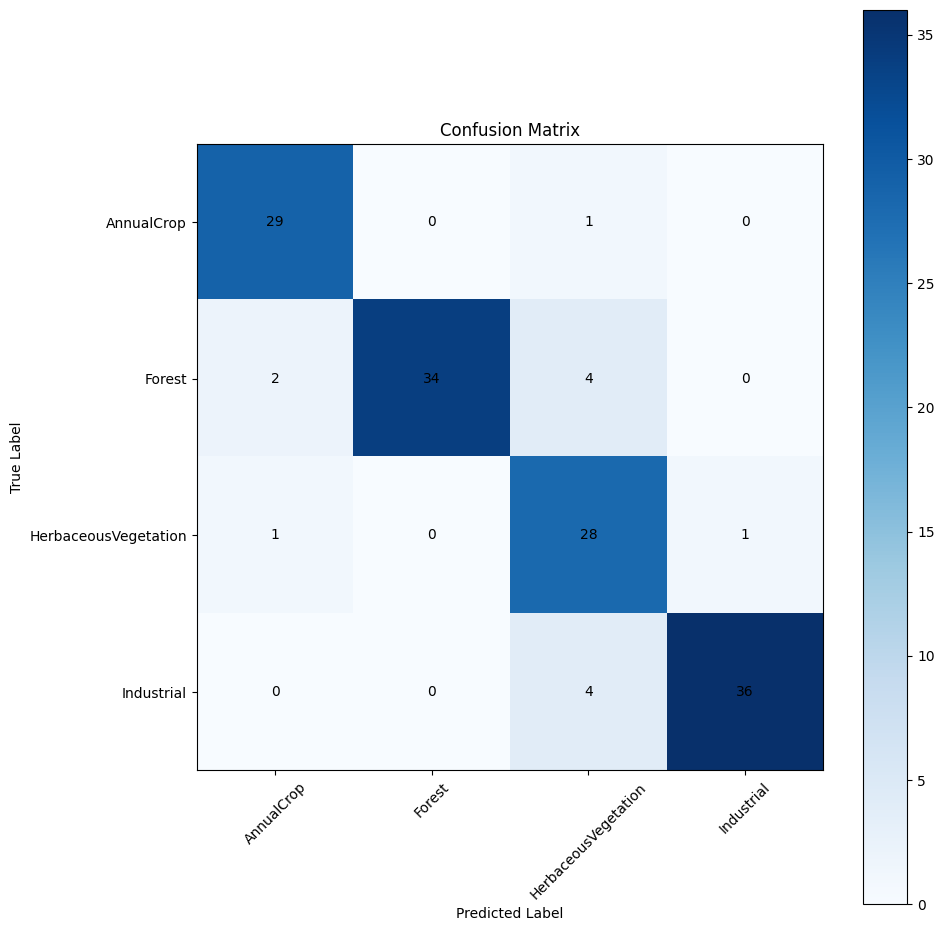

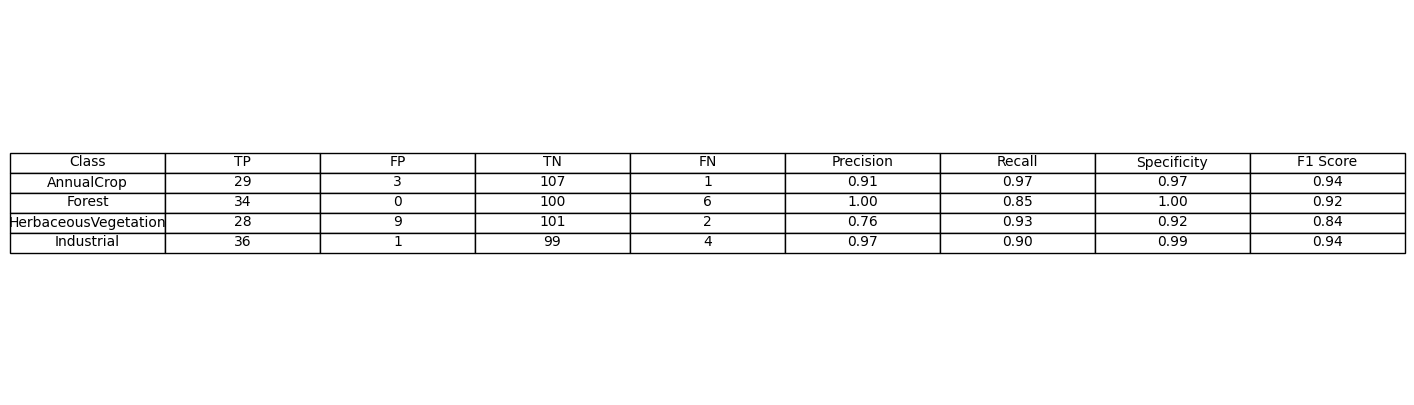

In [6]:
class_names = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Industrial"
]

# Testing loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha='center', va='center', color='black')
plt.show()

# Function to compute metrics from the confusion matrix
def compute_metrics(conf_matrix):
    metrics = {
        'Class': [],
        'TP': [],
        'FP': [],
        'TN': [],
        'FN': [],
        'Precision': [],
        'Recall': [],
        'Specificity': [],
        'F1 Score': []
    }

    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (FP + FN + TP)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics['Class'].append(class_names[i])
        metrics['TP'].append(TP)
        metrics['FP'].append(FP)
        metrics['TN'].append(TN)
        metrics['FN'].append(FN)
        metrics['Precision'].append(f"{precision:.2f}")
        metrics['Recall'].append(f"{recall:.2f}")
        metrics['Specificity'].append(f"{specificity:.2f}")
        metrics['F1 Score'].append(f"{f1_score:.2f}")

    return metrics

metrics = compute_metrics(conf_matrix)
metrics_df = pd.DataFrame(metrics)
def plot_metrics_table(metrics_df):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.show()
plot_metrics_table(metrics_df)

In [7]:
class_names = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Industrial"
]

image_path = '/content/drive/My Drive/EuroSAT_RGB/test_1.jpg'
image = Image.open(image_path)

# Apply the same transformations
image_tensor = test_transform(image).unsqueeze(0).to(device)

# Run the model to test
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = output.max(1)

# Get predicted class name and print
class_idx = predicted.item()
predicted_class_name = class_names[class_idx]
print(f"Predicted class: {predicted_class_name}")

Predicted class: AnnualCrop
